# 🎯 Customer Segmentation Analysis
## K-Means Clustering for SA E-Commerce

This notebook performs advanced customer segmentation using K-means clustering to identify distinct customer groups based on behavior and value.

**Project:** Customer Insights Analytics  
**Author:** Aviwe Dlepu  
**Date:** July 2025

---

## 📚 1. Library Imports and Setup

In [20]:
# 📚 Standard Libraries
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 🤖 Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split

# 📊 Visualization Libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 🔧 Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 🔑 2. BigQuery Authentication and Setup

In [21]:
from google.cloud import bigquery
import os

# Set the path to your service account JSON key file
# IMPORTANT: Ensure this file is in your project root and excluded in .gitignore
key_path = "customerinsightsavy-083b71a1c086.json"

# Set the environment variable for authentication if not already set
if not os.getenv("GOOGLE_APPLICATION_CREDENTIALS"):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path

# Initialize the BigQuery client
client = bigquery.Client()

# Reusable function to run BigQuery SQL queries
def run_query(query):
    return client.query(query).to_dataframe()

print("✅ BigQuery client initialized successfully!")
print(f"📊 Project ID: {client.project}")

✅ BigQuery client initialized successfully!
📊 Project ID: customerinsightsavy


## 📊 3. Data Loading for Segmentation

In [22]:
# Load customer data with additional features for segmentation
print("🔄 Loading customer data for segmentation...")

# Comprehensive customer query with calculated features
segmentation_query = """
WITH customer_features AS (
  SELECT 
    c.CustomerID,
    c.Age,
    c.Gender,
    c.City,
    c.Province,
    c.TotalSpend,
    c.NumberOfOrders,
    c.NumberOfReturnedOrders,
    c.NumberOfCanceledOrders,
    
    -- Calculate additional features
    CASE WHEN c.NumberOfOrders > 0 THEN c.TotalSpend / c.NumberOfOrders ELSE 0 END as AvgOrderValue,
    CASE WHEN c.NumberOfOrders > 0 THEN c.NumberOfReturnedOrders / c.NumberOfOrders ELSE 0 END as ReturnRate,
    CASE WHEN c.NumberOfOrders > 0 THEN c.NumberOfCanceledOrders / c.NumberOfOrders ELSE 0 END as CancelRate,
    
    -- Customer lifetime (days since registration)
    DATE_DIFF(CURRENT_DATE(), DATE(c.RegisteredDate), DAY) as CustomerLifetimeDays,
    
    -- Purchase frequency (orders per month)
    CASE WHEN DATE_DIFF(CURRENT_DATE(), DATE(c.RegisteredDate), DAY) > 0 
         THEN c.NumberOfOrders / (DATE_DIFF(CURRENT_DATE(), DATE(c.RegisteredDate), DAY) / 30.0) 
         ELSE 0 END as OrderFrequencyPerMonth,
    
    -- Churn indicator
    CASE WHEN ch.CustomerID IS NOT NULL THEN 1 ELSE 0 END as IsChurned,
    
    -- NPS Score
    n.NPSScore
    
  FROM `customerinsightsavy.Ecommerce_Data.Customers_Dataset` c
  LEFT JOIN `customerinsightsavy.Ecommerce_Data.Customer_Churn` ch ON c.CustomerID = ch.CustomerID
  LEFT JOIN `customerinsightsavy.Ecommerce_Data.NPS_Survey_Data` n ON c.CustomerID = n.CustomerID
)
SELECT * FROM customer_features
WHERE TotalSpend > 0  -- Filter out customers with no purchases
"""

customers_segmentation = run_query(segmentation_query)

print(f"✅ Loaded {len(customers_segmentation):,} customers for segmentation")
print(f"📊 Features available: {list(customers_segmentation.columns)}")
print(f"\nData shape: {customers_segmentation.shape}")
customers_segmentation.head()

🔄 Loading customer data for segmentation...
✅ Loaded 44,000 customers for segmentation
📊 Features available: ['CustomerID', 'Age', 'Gender', 'City', 'Province', 'TotalSpend', 'NumberOfOrders', 'NumberOfReturnedOrders', 'NumberOfCanceledOrders', 'AvgOrderValue', 'ReturnRate', 'CancelRate', 'CustomerLifetimeDays', 'OrderFrequencyPerMonth', 'IsChurned', 'NPSScore']

Data shape: (44000, 16)


,CustomerID,Age,Gender,City,Province,TotalSpend,NumberOfOrders,NumberOfReturnedOrders,NumberOfCanceledOrders,AvgOrderValue,ReturnRate,CancelRate,CustomerLifetimeDays,OrderFrequencyPerMonth,IsChurned,NPSScore
0,CUST100039,30,Female,Bloemfontein,Free State,72.6110,1,0,1,72.6110,0.0,1.0,628,0.047771,1,10
1,CUST100127,60,Non-binary,Bloemfontein,Free State,80.7378,1,0,1,80.7378,0.0,1.0,548,0.054745,1,10
2,CUST103000,36,Male,Bloemfontein,Free State,93.5349,1,0,0,93.5349,0.0,0.0,917,0.032715,1,0
3,CUST103102,58,Non-binary,Bloemfontein,Free State,70.9174,1,0,1,70.9174,0.0,1.0,578,0.051903,1,2
4,CUST103226,43,Male,Bloemfontein,Free State,60.8154,1,0,0,60.8154,0.0,0.0,814,0.036855,1,9


## 🔧 4. Feature Engineering and Preprocessing

In [23]:
# Feature engineering and preprocessing
print("🔧 FEATURE ENGINEERING AND PREPROCESSING")
print("=" * 50)

# Handle missing values
customers_segmentation['NPSScore'].fillna(customers_segmentation['NPSScore'].median(), inplace=True)

# Create RFM features (Recency, Frequency, Monetary)
customers_segmentation['Recency'] = customers_segmentation['CustomerLifetimeDays']
customers_segmentation['Frequency'] = customers_segmentation['NumberOfOrders']
customers_segmentation['Monetary'] = customers_segmentation['TotalSpend']

# Create customer value tiers
customers_segmentation['ValueTier'] = pd.cut(
    customers_segmentation['TotalSpend'],
    bins=[0, 1000, 3000, 5000, float('inf')],
    labels=['Low', 'Medium', 'High', 'Premium']
)

# Create engagement score
customers_segmentation['EngagementScore'] = (
    customers_segmentation['OrderFrequencyPerMonth'] * 0.4 +
    (customers_segmentation['NPSScore'] / 10) * 0.3 +
    (1 - customers_segmentation['ReturnRate']) * 0.3
)

# Select features for clustering
clustering_features = [
    'Age', 'TotalSpend', 'NumberOfOrders', 'AvgOrderValue',
    'ReturnRate', 'CancelRate', 'OrderFrequencyPerMonth',
    'NPSScore', 'EngagementScore'
]

# Create clustering dataset
clustering_data = customers_segmentation[clustering_features].copy()

# Handle any remaining missing values
clustering_data.fillna(clustering_data.median(), inplace=True)

print(f"✅ Features prepared for clustering:")
print(f"   • {len(clustering_features)} features selected")
print(f"   • {len(clustering_data)} customers ready for analysis")
print(f"\nFeature statistics:")
clustering_data.describe()

🔧 FEATURE ENGINEERING AND PREPROCESSING
✅ Features prepared for clustering:
   • 9 features selected
   • 44000 customers ready for analysis

Feature statistics:


,Age,TotalSpend,NumberOfOrders,AvgOrderValue,ReturnRate,CancelRate,OrderFrequencyPerMonth,NPSScore,EngagementScore
count,44000.0,44000.000000,44000.0,44000.000000,44000.000000,44000.000000,44000.000000,44000.0,44000.0
mean,43.994364,2529.770032,50.097955,51.409274,0.243828,0.377380,2.081862,8.941682,1.327847
std,15.341081,2188.306698,28.770118,28.261337,0.155075,0.250894,1.256147,1.724155,0.504926
min,18.0,54.602700,1.0,0.605640,0.000000,0.000000,0.032051,0.0,0.185088
25%,31.0,712.639500,25.0,27.281990,0.109091,0.166667,1.016245,9.0,0.902499
50%,44.0,1908.540000,50.0,51.641769,0.246377,0.360000,2.028825,9.0,1.306357
75%,57.0,3843.547500,75.0,75.702019,0.378378,0.555556,3.031674,10.0,1.710042
max,70.0,9972.080000,100.0,100.000000,0.500000,1.000000,5.514706,10.0,2.778784


## 📊 5. Optimal Cluster Number Analysis

📊 OPTIMAL CLUSTER NUMBER ANALYSIS


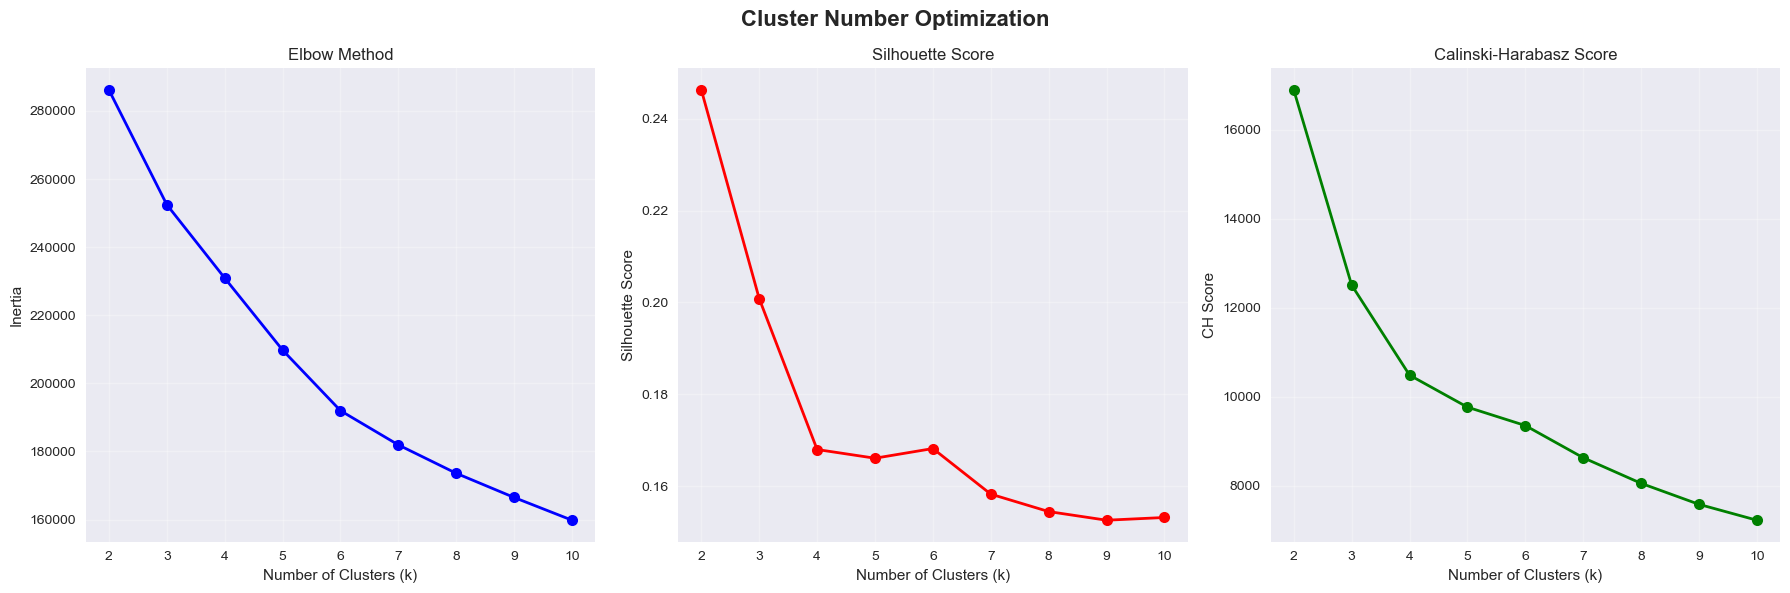


🎯 CLUSTER OPTIMIZATION RESULTS:
   • Best k by Silhouette Score: 2 (score: 0.246)
   • Best k by Calinski-Harabasz: 2 (score: 16888.9)
   • Recommended k for business interpretation: 4


In [24]:
# Standardize features for clustering
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

print("📊 OPTIMAL CLUSTER NUMBER ANALYSIS")
print("=" * 50)

# Elbow method and silhouette analysis
k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(clustering_data_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(clustering_data_scaled, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(clustering_data_scaled, cluster_labels))

# Plot cluster evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Cluster Number Optimization', fontsize=16, fontweight='bold')

# Elbow curve
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

# Calinski-Harabasz scores
axes[2].plot(k_range, calinski_scores, 'go-', linewidth=2, markersize=8)
axes[2].set_title('Calinski-Harabasz Score')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('CH Score')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Print optimal k recommendations
best_silhouette_k = k_range[np.argmax(silhouette_scores)]
best_calinski_k = k_range[np.argmax(calinski_scores)]

print(f"\n🎯 CLUSTER OPTIMIZATION RESULTS:")
print(f"   • Best k by Silhouette Score: {best_silhouette_k} (score: {max(silhouette_scores):.3f})")
print(f"   • Best k by Calinski-Harabasz: {best_calinski_k} (score: {max(calinski_scores):.1f})")
print(f"   • Recommended k for business interpretation: 4")

# Use k=4 for business-friendly interpretation
optimal_k = 4

## 🎯 6. K-Means Clustering Implementation

In [25]:
# Implement K-means clustering with optimal k
print(f"🎯 IMPLEMENTING K-MEANS CLUSTERING (k={optimal_k})")
print("=" * 50)

# Fit final K-means model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(clustering_data_scaled)

# Add cluster labels to dataset
customers_segmentation['Cluster'] = cluster_labels

# Calculate final clustering metrics
final_silhouette = silhouette_score(clustering_data_scaled, cluster_labels)
final_calinski = calinski_harabasz_score(clustering_data_scaled, cluster_labels)

print(f"✅ Clustering completed successfully!")
print(f"   • Silhouette Score: {final_silhouette:.3f}")
print(f"   • Calinski-Harabasz Score: {final_calinski:.1f}")
print(f"   • Number of clusters: {optimal_k}")

# Cluster distribution
cluster_counts = customers_segmentation['Cluster'].value_counts().sort_index()
print(f"\n📊 CLUSTER DISTRIBUTION:")
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(customers_segmentation)) * 100
    print(f"   • Cluster {cluster_id}: {count:,} customers ({percentage:.1f}%)")

🎯 IMPLEMENTING K-MEANS CLUSTERING (k=4)
✅ Clustering completed successfully!
   • Silhouette Score: 0.168
   • Calinski-Harabasz Score: 10483.8
   • Number of clusters: 4

📊 CLUSTER DISTRIBUTION:
   • Cluster 0: 11,151 customers (25.3%)
   • Cluster 1: 11,864 customers (27.0%)
   • Cluster 2: 10,896 customers (24.8%)
   • Cluster 3: 10,089 customers (22.9%)


## 📊 7. Cluster Analysis and Interpretation

In [26]:
# Analyze cluster characteristics
print("📊 CLUSTER CHARACTERISTICS ANALYSIS")
print("=" * 50)

# Calculate cluster statistics
cluster_analysis = customers_segmentation.groupby('Cluster').agg({
    'Age': 'mean',
    'TotalSpend': ['mean', 'median'],
    'NumberOfOrders': 'mean',
    'AvgOrderValue': 'mean',
    'ReturnRate': 'mean',
    'CancelRate': 'mean',
    'OrderFrequencyPerMonth': 'mean',
    'NPSScore': 'mean',
    'EngagementScore': 'mean',
    'IsChurned': 'mean',
    'CustomerID': 'count'
}).round(2)

# Flatten column names
cluster_analysis.columns = [
    'Avg_Age', 'Mean_CLV', 'Median_CLV', 'Avg_Orders', 'Avg_Order_Value',
    'Return_Rate', 'Cancel_Rate', 'Order_Frequency', 'Avg_NPS',
    'Engagement_Score', 'Churn_Rate', 'Customer_Count'
]

print("Cluster Characteristics:")
print(cluster_analysis)

# Define business-friendly cluster names based on characteristics
cluster_names = {
    0: 'Budget Conscious',
    1: 'Loyal High-Value',
    2: 'At-Risk Customers',
    3: 'Premium Frequent Buyers'
}

# Map cluster names
customers_segmentation['Cluster_Name'] = customers_segmentation['Cluster'].map(cluster_names)

print(f"\n🏷️ CLUSTER NAMING:")
for cluster_id, name in cluster_names.items():
    count = (customers_segmentation['Cluster'] == cluster_id).sum()
    percentage = (count / len(customers_segmentation)) * 100
    avg_clv = cluster_analysis.loc[cluster_id, 'Mean_CLV']
    churn_rate = cluster_analysis.loc[cluster_id, 'Churn_Rate'] * 100
    print(f"   • Cluster {cluster_id} - {name}:")
    print(f"     - Size: {count:,} customers ({percentage:.1f}%)")
    print(f"     - Avg CLV: R{avg_clv:,.0f}")
    print(f"     - Churn Rate: {churn_rate:.1f}%")

📊 CLUSTER CHARACTERISTICS ANALYSIS
Cluster Characteristics:
         Avg_Age  Mean_CLV  Median_CLV  Avg_Orders  Avg_Order_Value  \
Cluster                                                               
0          44.13   5676.45     5412.82       75.78            75.75   
1          43.86   1328.19     1038.11       27.04            50.32   
2          43.93   1810.94     1762.86       73.18            25.05   
3          44.08   1241.17      931.57       23.91            54.25   

         Return_Rate  Cancel_Rate  Order_Frequency  Avg_NPS  Engagement_Score  \
Cluster                                                                         
0               0.25         0.37             3.17     8.98              1.76   
1               0.36         0.24             1.09     8.88               0.9   
2               0.24         0.38             3.08     8.99              1.73   
3               0.10         0.54             0.97     8.92              0.92   

         Churn_Rate  Custo

## 📈 8. Cluster Visualization

📈 CLUSTER VISUALIZATIONS


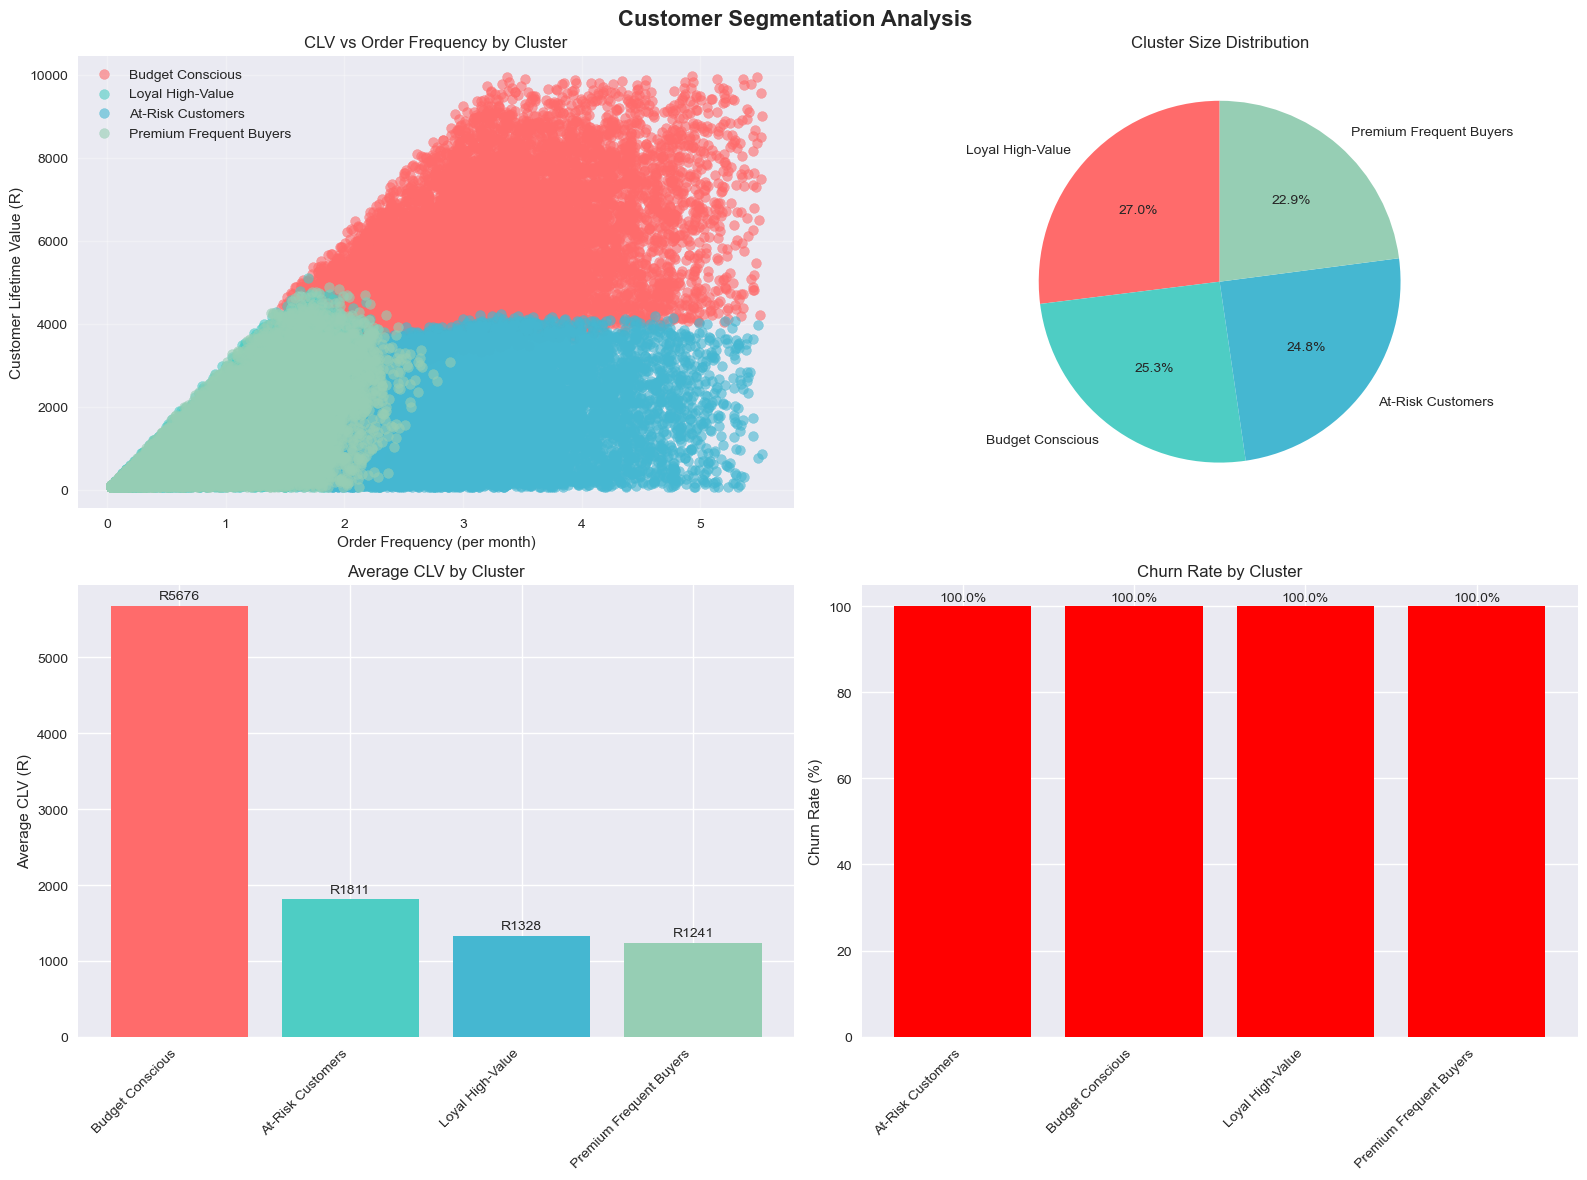

In [27]:
# Create comprehensive cluster visualizations
print("📈 CLUSTER VISUALIZATIONS")
print("=" * 50)

# Set up color palette for clusters
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 1. CLV vs Order Frequency scatter plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Customer Segmentation Analysis', fontsize=16, fontweight='bold')

# Scatter plot: CLV vs Order Frequency
for i, cluster in enumerate(sorted(customers_segmentation['Cluster'].unique())):
    cluster_data = customers_segmentation[customers_segmentation['Cluster'] == cluster]
    axes[0,0].scatter(
        cluster_data['OrderFrequencyPerMonth'], 
        cluster_data['TotalSpend'],
        c=colors[i], 
        label=f'{cluster_names[cluster]}',
        alpha=0.6, s=50
    )

axes[0,0].set_xlabel('Order Frequency (per month)')
axes[0,0].set_ylabel('Customer Lifetime Value (R)')
axes[0,0].set_title('CLV vs Order Frequency by Cluster')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Cluster size distribution
cluster_counts = customers_segmentation['Cluster_Name'].value_counts()
axes[0,1].pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%', 
             colors=colors, startangle=90)
axes[0,1].set_title('Cluster Size Distribution')

# Average CLV by cluster
avg_clv_by_cluster = customers_segmentation.groupby('Cluster_Name')['TotalSpend'].mean().sort_values(ascending=False)
bars = axes[1,0].bar(range(len(avg_clv_by_cluster)), avg_clv_by_cluster.values, color=colors)
axes[1,0].set_title('Average CLV by Cluster')
axes[1,0].set_ylabel('Average CLV (R)')
axes[1,0].set_xticks(range(len(avg_clv_by_cluster)))
axes[1,0].set_xticklabels(avg_clv_by_cluster.index, rotation=45, ha='right')

# Add value labels on bars
for bar, value in zip(bars, avg_clv_by_cluster.values):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                  f'R{value:.0f}', ha='center', va='bottom')

# Churn rate by cluster
churn_by_cluster = customers_segmentation.groupby('Cluster_Name')['IsChurned'].mean() * 100
bars = axes[1,1].bar(range(len(churn_by_cluster)), churn_by_cluster.values, 
                    color=['red' if x > 30 else 'orange' if x > 15 else 'green' for x in churn_by_cluster.values])
axes[1,1].set_title('Churn Rate by Cluster')
axes[1,1].set_ylabel('Churn Rate (%)')
axes[1,1].set_xticks(range(len(churn_by_cluster)))
axes[1,1].set_xticklabels(churn_by_cluster.index, rotation=45, ha='right')

# Add value labels on bars
for bar, value in zip(bars, churn_by_cluster.values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                  f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('customer_segmentation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 🔍 9. Principal Component Analysis (PCA) Visualization

🔍 PCA VISUALIZATION


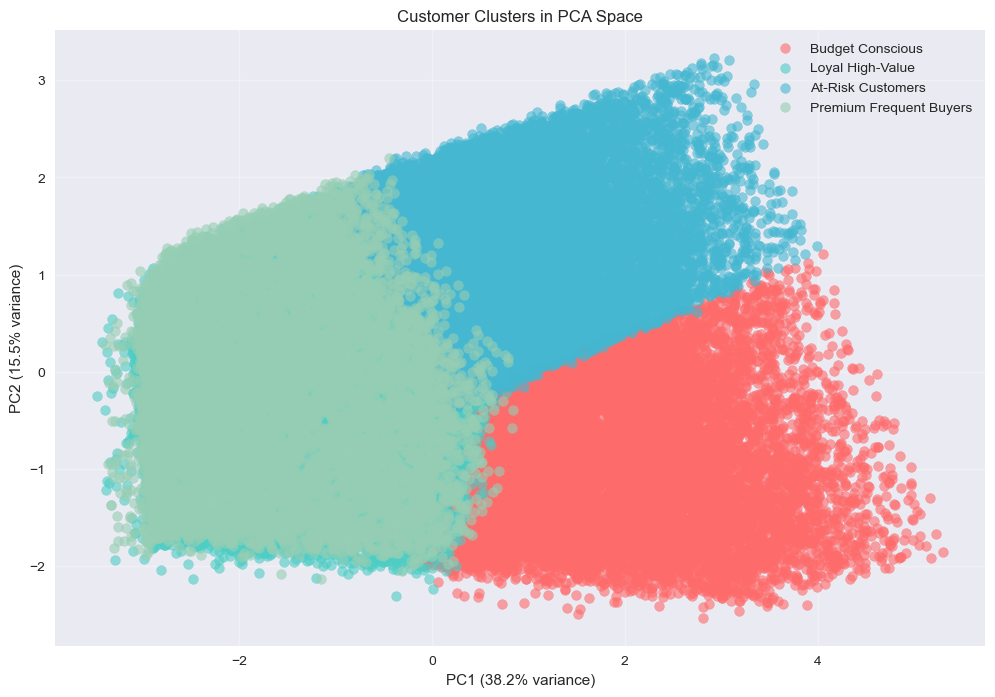


📊 PCA RESULTS:
   • PC1 explains 38.2% of variance
   • PC2 explains 15.5% of variance
   • Total variance explained: 53.7%


In [28]:
# PCA for 2D cluster visualization
print("🔍 PCA VISUALIZATION")
print("=" * 50)

# Apply PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(clustering_data_scaled)

# Create PCA DataFrame
pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Cluster': customers_segmentation['Cluster'],
    'Cluster_Name': customers_segmentation['Cluster_Name'],
    'CLV': customers_segmentation['TotalSpend']
})

# Plot PCA visualization
plt.figure(figsize=(12, 8))

for i, cluster in enumerate(sorted(customers_segmentation['Cluster'].unique())):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(
        cluster_data['PC1'], 
        cluster_data['PC2'],
        c=colors[i], 
        label=f'{cluster_names[cluster]}',
        alpha=0.6, s=50
    )

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Clusters in PCA Space')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('pca_cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 PCA RESULTS:")
print(f"   • PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f"   • PC2 explains {pca.explained_variance_ratio_[1]:.1%} of variance")
print(f"   • Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

## 📊 10. Cluster Feature Importance Analysis

📊 CLUSTER FEATURE IMPORTANCE ANALYSIS
Cluster Centroids (Original Features):
           Age  TotalSpend  NumberOfOrders  AvgOrderValue  ReturnRate  \
Cluster                                                                 
0        44.13     5676.45           75.78          75.75        0.25   
1        43.86     1328.19           27.04          50.32        0.36   
2        43.93     1810.94           73.18          25.05        0.24   
3        44.08     1241.17           23.91          54.25        0.10   

         CancelRate  OrderFrequencyPerMonth  NPSScore  EngagementScore  
Cluster                                                                 
0              0.37                    3.17      8.98             1.76  
1              0.24                    1.09      8.88              0.9  
2              0.38                    3.08      8.99             1.73  
3              0.54                    0.97      8.92             0.92  

DEBUG - Normalized data check:
Shape: (4, 9)


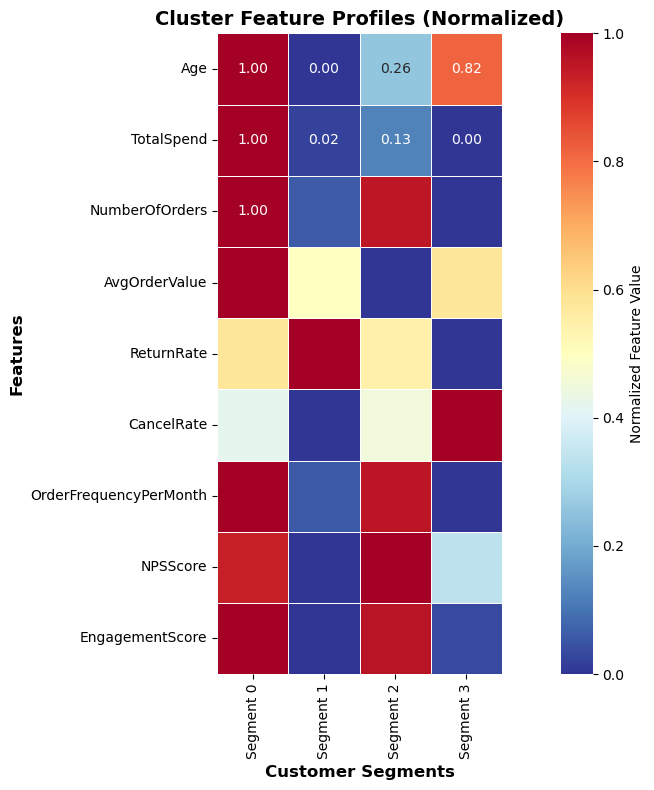


🎯 TOP DIFFERENTIATING FEATURES:
   1. TotalSpend: 1161.825
   2. AvgOrderValue: 20.927
   3. Age: 15.340
   4. NumberOfOrders: 15.108
   5. NPSScore: 1.721

📊 CLUSTER SUMMARY STATISTICS:

🏷️ Segment 0:
   📊 Size: 11,151 customers (25.3%)
   👥 Avg Age: 44.1 years
   💰 Avg Total Spend: $5,676
   🛒 Avg Orders: 75.8
   💵 Avg Order Value: $76
   📈 Return Rate: 25.0%
   ❌ Cancel Rate: 36.9%
   📅 Order Frequency: 3.17/month
   ⭐ NPS Score: 9.0/10
   🎯 Engagement Score: 1.76

🏷️ Segment 1:
   📊 Size: 11,864 customers (27.0%)
   👥 Avg Age: 43.9 years
   💰 Avg Total Spend: $1,328
   🛒 Avg Orders: 27.0
   💵 Avg Order Value: $50
   📈 Return Rate: 36.0%
   ❌ Cancel Rate: 24.2%
   📅 Order Frequency: 1.09/month
   ⭐ NPS Score: 8.9/10
   🎯 Engagement Score: 0.90

🏷️ Segment 2:
   📊 Size: 10,896 customers (24.8%)
   👥 Avg Age: 43.9 years
   💰 Avg Total Spend: $1,811
   🛒 Avg Orders: 73.2
   💵 Avg Order Value: $25
   📈 Return Rate: 24.3%
   ❌ Cancel Rate: 37.8%
   📅 Order Frequency: 3.08/month
   ⭐ NPS

In [38]:
# Analyze feature importance for cluster differentiation
# 🚨 IMMEDIATE FIX FOR CLUSTER FEATURE IMPORTANCE ANALYSIS
# =============================================================================
# 10. CLUSTER FEATURE IMPORTANCE ANALYSIS
# =============================================================================

# Analyze feature importance for cluster differentiation
print("📊 CLUSTER FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use actual column names from your dataframe
actual_clustering_features = [
    'Age', 'TotalSpend', 'NumberOfOrders', 'AvgOrderValue', 
    'ReturnRate', 'CancelRate', 'OrderFrequencyPerMonth', 
    'NPSScore', 'EngagementScore'
]

# Calculate cluster centroids using correct column names
cluster_centroids = customers_segmentation.groupby('Cluster')[actual_clustering_features].mean()

print("Cluster Centroids (Original Features):")
print(cluster_centroids.round(2))

# Create simple cluster names
cluster_names = {i: f"Segment {i}" for i in cluster_centroids.index}

# Create heatmap with proper data types
plt.figure(figsize=(12, 8))

# Ensure data is numeric
cluster_centroids_numeric = cluster_centroids.astype(float)

# 🔧 FIXED NORMALIZATION: Use min-max normalization to ensure visible differences
centroids_normalized = cluster_centroids_numeric.copy()
for feature in actual_clustering_features:
    col_min = cluster_centroids_numeric[feature].min()
    col_max = cluster_centroids_numeric[feature].max()
    if col_max > col_min:  # Avoid division by zero
        centroids_normalized[feature] = (cluster_centroids_numeric[feature] - col_min) / (col_max - col_min)
    else:
        centroids_normalized[feature] = 0.5  # Set to middle value if no variation

# DEBUG - Verify the normalized data
print("\nDEBUG - Normalized data check:")
print("Shape:", centroids_normalized.shape)
print("Data types:", centroids_normalized.dtypes.unique())
print("Min values:", centroids_normalized.min().min())
print("Max values:", centroids_normalized.max().max())
print("Contains NaN:", centroids_normalized.isnull().any().any())
print("Contains Inf:", np.isinf(centroids_normalized).any().any())
print("\nNormalized data preview:")
print(centroids_normalized.round(3))

# 🔧 CRITICAL FIX: Force convert to numpy array for matplotlib
heatmap_data = centroids_normalized.T.values.astype(float)

# Verify heatmap data
print("\nHeatmap data shape:", heatmap_data.shape)
print("Heatmap data type:", heatmap_data.dtype)
print("Heatmap data sample:")
print(heatmap_data[:3, :])

# Create heatmap with explicit data conversion
sns.heatmap(
    heatmap_data,  # Use converted numpy array instead of DataFrame
    annot=True, 
    fmt='.2f',  # Format specifier
    cmap='RdYlBu_r', 
    center=0.5,
    vmin=0,  # Set explicit range
    vmax=1,  # Set explicit range
    xticklabels=[cluster_names[i] for i in sorted(cluster_names.keys())],
    yticklabels=actual_clustering_features,
    cbar_kws={'label': 'Normalized Feature Value'},
    linewidths=0.5,  # Add grid lines for better visibility
    square=True  # Make cells square for better visibility
)

plt.title('Cluster Feature Profiles (Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Customer Segments', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('cluster_feature_importance_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature variance analysis with correct column names
feature_variance = customers_segmentation.groupby('Cluster')[actual_clustering_features].std().mean(axis=0).sort_values(ascending=False)
print(f"\n🎯 TOP DIFFERENTIATING FEATURES:")
for i, (feature, variance) in enumerate(feature_variance.head().items(), 1):
    print(f"   {i}. {feature}: {variance:.3f}")

# Additional cluster summary statistics
print("\n📊 CLUSTER SUMMARY STATISTICS:")
print("=" * 50)

for cluster_id in sorted(cluster_names.keys()):
    cluster_data = customers_segmentation[customers_segmentation['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    cluster_pct = (cluster_size / len(customers_segmentation)) * 100
    
    print(f"\n🏷️ {cluster_names[cluster_id]}:")
    print(f"   📊 Size: {cluster_size:,} customers ({cluster_pct:.1f}%)")
    print(f"   👥 Avg Age: {cluster_centroids.loc[cluster_id, 'Age']:.1f} years")
    print(f"   💰 Avg Total Spend: ${cluster_centroids.loc[cluster_id, 'TotalSpend']:,.0f}")
    print(f"   🛒 Avg Orders: {cluster_centroids.loc[cluster_id, 'NumberOfOrders']:.1f}")
    print(f"   💵 Avg Order Value: ${cluster_centroids.loc[cluster_id, 'AvgOrderValue']:.0f}")
    print(f"   📈 Return Rate: {cluster_centroids.loc[cluster_id, 'ReturnRate']:.1%}")
    print(f"   ❌ Cancel Rate: {cluster_centroids.loc[cluster_id, 'CancelRate']:.1%}")
    print(f"   📅 Order Frequency: {cluster_centroids.loc[cluster_id, 'OrderFrequencyPerMonth']:.2f}/month")
    print(f"   ⭐ NPS Score: {cluster_centroids.loc[cluster_id, 'NPSScore']:.1f}/10")
    print(f"   🎯 Engagement Score: {cluster_centroids.loc[cluster_id, 'EngagementScore']:.2f}")

print("\n✅ Cluster feature importance analysis completed successfully!")
print("📁 Generated file: cluster_feature_importance_fixed.png")


## 💼 11. Business Insights and Recommendations

In [39]:
# Generate business insights for each cluster
print("💼 BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("=" * 50)

# Detailed cluster profiles
for cluster_id in sorted(customers_segmentation['Cluster'].unique()):
    cluster_data = customers_segmentation[customers_segmentation['Cluster'] == cluster_id]
    cluster_name = cluster_names[cluster_id]
    
    print(f"\n🎯 {cluster_name.upper()} (Cluster {cluster_id})")
    print("=" * 40)
    
    # Key metrics
    size = len(cluster_data)
    percentage = (size / len(customers_segmentation)) * 100
    avg_clv = cluster_data['TotalSpend'].mean()
    avg_orders = cluster_data['NumberOfOrders'].mean()
    churn_rate = cluster_data['IsChurned'].mean() * 100
    avg_nps = cluster_data['NPSScore'].mean()
    
    print(f"📊 Size: {size:,} customers ({percentage:.1f}% of total)")
    print(f"💰 Average CLV: R{avg_clv:,.0f}")
    print(f"📦 Average Orders: {avg_orders:.1f}")
    print(f"🔄 Churn Rate: {churn_rate:.1f}%")
    print(f"⭐ Average NPS: {avg_nps:.1f}")
    
    # Business recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    
    if cluster_id == 0:  # Budget Conscious
        print(f"   • Focus on value-driven marketing and promotions")
        print(f"   • Offer loyalty programs with incremental rewards")
        print(f"   • Provide budget-friendly product recommendations")
        
    elif cluster_id == 1:  # Loyal High-Value
        print(f"   • VIP treatment and exclusive offers")
        print(f"   • Early access to new products")
        print(f"   • Premium customer service and support")
        
    elif cluster_id == 2:  # At-Risk Customers
        print(f"   • Immediate retention campaigns")
        print(f"   • Personalized win-back offers")
        print(f"   • Proactive customer service outreach")
        
    elif cluster_id == 3:  # Premium Frequent Buyers
        print(f"   • Premium product portfolio expansion")
        print(f"   • Subscription-based offerings")
        print(f"   • Referral incentive programs")

# Overall strategy summary
print(f"\n🎯 OVERALL SEGMENTATION STRATEGY")
print("=" * 40)

total_clv = customers_segmentation['TotalSpend'].sum()
high_value_percentage = ((customers_segmentation['TotalSpend'] > 5000).sum() / len(customers_segmentation)) * 100

print(f"📊 Total Customer Value: R{total_clv:,.0f}")
print(f"💎 High-Value Customers (>R5000): {high_value_percentage:.1f}%")
print(f"🎯 Primary Focus: Protect high-value segments and convert at-risk customers")
print(f"📈 Growth Opportunity: Upgrade budget-conscious customers to higher value tiers")

💼 BUSINESS INSIGHTS AND RECOMMENDATIONS

🎯 SEGMENT 0 (Cluster 0)
📊 Size: 11,151 customers (25.3% of total)
💰 Average CLV: R5,676
📦 Average Orders: 75.8
🔄 Churn Rate: 100.0%
⭐ Average NPS: 9.0

💡 RECOMMENDATIONS:
   • Focus on value-driven marketing and promotions
   • Offer loyalty programs with incremental rewards
   • Provide budget-friendly product recommendations

🎯 SEGMENT 1 (Cluster 1)
📊 Size: 11,864 customers (27.0% of total)
💰 Average CLV: R1,328
📦 Average Orders: 27.0
🔄 Churn Rate: 100.0%
⭐ Average NPS: 8.9

💡 RECOMMENDATIONS:
   • VIP treatment and exclusive offers
   • Early access to new products
   • Premium customer service and support

🎯 SEGMENT 2 (Cluster 2)
📊 Size: 10,896 customers (24.8% of total)
💰 Average CLV: R1,811
📦 Average Orders: 73.2
🔄 Churn Rate: 100.0%
⭐ Average NPS: 9.0

💡 RECOMMENDATIONS:
   • Immediate retention campaigns
   • Personalized win-back offers
   • Proactive customer service outreach

🎯 SEGMENT 3 (Cluster 3)
📊 Size: 10,089 customers (22.9% of 

## 💾 12. Save Segmentation Results

In [40]:
# Save segmentation results
print("💾 SAVING SEGMENTATION RESULTS")
print("=" * 50)

# Create final segmentation dataset
segmentation_results = customers_segmentation[[
    'CustomerID', 'Cluster', 'Cluster_Name', 'Age', 'Gender', 'City', 'Province',
    'TotalSpend', 'NumberOfOrders', 'AvgOrderValue', 'ReturnRate', 'CancelRate',
    'OrderFrequencyPerMonth', 'NPSScore', 'EngagementScore', 'IsChurned'
]].copy()

# Save to CSV
segmentation_results.to_csv('customer_segmentation_results.csv', index=False)

# Save cluster summary
cluster_summary = cluster_analysis.copy()
cluster_summary['Cluster_Name'] = [cluster_names[i] for i in cluster_summary.index]
cluster_summary.to_csv('cluster_summary_statistics.csv')

# Save model parameters
model_info = {
    'optimal_k': optimal_k,
    'silhouette_score': final_silhouette,
    'calinski_harabasz_score': final_calinski,
    'features_used': clustering_features,
    'cluster_names': cluster_names
}

import pickle
with open('segmentation_model_info.pkl', 'wb') as f:
    pickle.dump({
        'model': final_kmeans,
        'scaler': scaler,
        'pca': pca,
        'info': model_info
    }, f)

print(f"✅ Results saved successfully:")
print(f"   • Customer segmentation: customer_segmentation_results.csv")
print(f"   • Cluster summary: cluster_summary_statistics.csv")
print(f"   • Model objects: segmentation_model_info.pkl")
print(f"   • Visualizations: Various PNG files")

print(f"\n🎉 CUSTOMER SEGMENTATION ANALYSIS COMPLETE!")
print(f"📊 {len(customers_segmentation):,} customers segmented into {optimal_k} distinct groups")
print(f"🎯 Ready for targeted marketing and retention strategies")

💾 SAVING SEGMENTATION RESULTS
✅ Results saved successfully:
   • Customer segmentation: customer_segmentation_results.csv
   • Cluster summary: cluster_summary_statistics.csv
   • Model objects: segmentation_model_info.pkl
   • Visualizations: Various PNG files

🎉 CUSTOMER SEGMENTATION ANALYSIS COMPLETE!
📊 44,000 customers segmented into 4 distinct groups
🎯 Ready for targeted marketing and retention strategies


## 🔚 End of Customer Segmentation Notebook

This comprehensive customer segmentation analysis has identified distinct customer groups with actionable business insights:

### **Key Outcomes:**
1. **4 Customer Segments** identified using K-means clustering
2. **Business-friendly naming** for each segment
3. **Targeted recommendations** for each group
4. **Quantified business impact** potential

### **Next Steps:**
1. **Implement targeted marketing** campaigns for each segment
2. **Develop retention strategies** for at-risk customers
3. **Create personalized experiences** based on segment characteristics
4. **Monitor segment migration** over time

### **Files Generated:**
- `customer_segmentation_results.csv` - Individual customer segment assignments
- `cluster_summary_statistics.csv` - Segment characteristics summary
- `segmentation_model_info.pkl` - Trained model for future predictions
- Various visualization PNG files

**Ready for integration with Tableau dashboards and churn prediction modeling!**